In [2]:
import tensorflow as tf
# Define and get the number os devices. 
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

2024-06-16 11:45:05.417376: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 11:45:05.417470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 11:45:05.540624: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


DEVICES AVAILABLE: 2


In [4]:
# Import standard dependencies
import random
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm import tqdm

import tensorflow as tf
import tensorflow_io as tfio
# Import tensorflow dependencies - Functional API


# image preprocessing
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator, load_img

# to build model
from keras.models import Model
from tensorflow.keras.layers import Rescaling, Input, Conv2D, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.activations import softmax

# cost function / optimizer
from tensorflow.keras.optimizers import SGD, Adamax
from sklearn.metrics import confusion_matrix

In [5]:
SEED = 178
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [6]:
# tqdm
train_paths = []
test_paths = []
train_labels = []
test_labels = []

live_train = 0
live_test = 0
spoof_train = 0
spoof_test = 0


train_test = ['/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train', '/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test']
for i in range(2):
    for file in tqdm(os.listdir(train_test[i])):
        d = os.path.join(train_test[i], file)
        if os.path.isdir(d):
            for e in os.listdir(d):
                imgs_path = d + '/' + e + '/'
                for img_path in os.listdir(imgs_path):
                    if (img_path.endswith(".jpg") or img_path.endswith(".png")):
                        if(img_path=='004046.jpg'):
                            continue
                        full_img_path = imgs_path + img_path
                        if(i==0): #train
                            train_paths.append(full_img_path)
                            if e == 'live':
                                live_train = live_train + 1
                                train_labels.append(1)
                            elif e == 'spoof':
                                spoof_train = spoof_train + 1
                                train_labels.append(0)
                        else:
                            test_paths.append(full_img_path)
                            if e == 'live':
                                live_test = live_test + 1
                                test_labels.append(1)
                            elif e == 'spoof':
                                spoof_test = spoof_test + 1
                                test_labels.append(0)

print(len(train_paths),len(train_labels),len(test_paths),len(test_labels))
print(live_train, live_test, spoof_train, spoof_test)

100%|██████████| 1004/1004 [00:34<00:00, 29.05it/s]

494404 494404 67170 67170
164484 19923 329920 47247


In [7]:
ds = tf.data.Dataset.from_tensor_slices((train_paths[:5000],train_labels[:5000])).shuffle(1000)
test_ds = tf.data.Dataset.from_tensor_slices((test_paths,test_labels))

for element in ds.take(1):
    print(element)
for element in test_ds.take(1):
    print(element)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/train/9350/live/437123.jpg'>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/celeba-spoof-for-face-antispoofing/CelebA_Spoof_/CelebA_Spoof/Data/test/5550/live/526975.png'>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)


In [8]:
def get_ratio_bbox_and_image(shape, bound_box_path):
    real_h, real_w, _ = shape
    area_image = real_h * real_w
    x1, y1, w1, h1 = get_area_bbox_indices(bound_box_path, real_w, real_h)
    area_bbox = w1*h1
    return area_bbox / area_image


def standard_width_height_scaling(real_w, real_h, bbox0, bbox1, bbox2, bbox3):
    x1 = int(int(bbox0)*(float(real_w) / 224)) 
    y1 = int(int(bbox1)*(float(real_h) / 224)) 
    w1 = int(int(bbox2)*(float(real_w) / 224)) 
    h1 = int(int(bbox3)*(float(real_h) / 224)) 
    return x1, y1, w1, h1


def get_area_bbox_indices(bound_box_path, real_w, real_h):
    bound_box_read = open(bound_box_path, "r")
    bound_box_indices = list()
    for i in bound_box_read:
        bound_box_indices.append(i)
    bbox = bound_box_indices[0].split()
    x1, y1, w1, h1 = standard_width_height_scaling(real_w, real_h, bbox[0], bbox[1], bbox[2], bbox[3])
    return x1, y1, w1, h1

def get_padding_bbox_indices(x1, y1, w1, h1, real_w, real_h, ratio_bbox_and_image):
    x1_padding = x1 - int((w1) * (1+ratio_bbox_and_image))
    y1_padding = y1 - int((h1) * (1+ratio_bbox_and_image))
    w1_padding = w1 + int((w1) * (1+ratio_bbox_and_image))
    h1_padding = h1 + int((h1) * (1+ratio_bbox_and_image))
    if x1_padding < 0: 
        x1_padding = 0
    if y1_padding < 0:
        y1_padding = 0
    if w1_padding > real_w:
        w1_padding = real_w
    if h1_padding > real_h:
        h1_padding = real_h
    return x1_padding, y1_padding, w1_padding, h1_padding
    
def read_crop_img_with_bbox(shape, bound_box_path):
    real_h, real_w, _ = shape
    x1, y1, w1, h1 = get_area_bbox_indices(bound_box_path, real_w, real_h)
    return x1, y1, w1, h1, real_w, real_h

In [9]:
def process_path_and_bbox(img_path, real_h, real_w, channels):
    img_path_str = img_path.numpy().decode('utf-8')
    bound_box_path = img_path_str[:-4] + '_BB.txt'
    shape = (real_h.numpy(), real_w.numpy(), channels.numpy())
    x1, y1, w1, h1, real_w, real_h = read_crop_img_with_bbox(shape, bound_box_path)
    ratio_bbox_and_image = get_ratio_bbox_and_image(shape, bound_box_path)
    x1_padding, y1_padding, w1_padding, h1_padding = get_padding_bbox_indices(
        x1, y1, w1, h1, real_w, real_h, ratio_bbox_and_image
    )
    return x1_padding, y1_padding, w1_padding, h1_padding

In [10]:
imgShape = [71, 71, 3]
def preprocess(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_image(img, channels=3)
    
    # Ensure that img has a known shape
    img = tf.ensure_shape(img, [None, None, 3])
    
    shape = tf.shape(img)
    real_h, real_w, channels = shape[0], shape[1], shape[2]

    x1_padding, y1_padding, w1_padding, h1_padding = tf.py_function(
        func=process_path_and_bbox,
        inp=[img_path, real_h, real_w, channels],
        Tout=[tf.int32, tf.int32, tf.int32, tf.int32]
    )
    
    # Very important to set the shape of py_function outputs
    # Ensure shapes are defined 
    x1_padding.set_shape([])
    y1_padding.set_shape([])
    w1_padding.set_shape([])
    h1_padding.set_shape([])

    img = img[y1_padding:y1_padding + h1_padding, x1_padding:x1_padding + w1_padding]

    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=imgShape[:2])
    
    # Cast image to uint8 before converting to YCbCr
    img = tf.cast(img, tf.uint8)
    img = tfio.experimental.color.rgb_to_ycbcr(img)
    
    # Normalize each channel to the range [-1, 1] using ((x-min)/(max-min)) - 1
    min_vals = tf.constant([16, 16, 16], dtype=tf.float32)
    max_vals = tf.constant([235, 239, 239], dtype=tf.float32)
    
    img = tf.cast(img, tf.float32)
    img = (img - min_vals) / (max_vals - min_vals) - 1

    return img, label

In [11]:
examples_count = tf.data.experimental.cardinality(ds).numpy()
print(examples_count)
train_size = int(examples_count * 0.90)
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size)
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

AUTOTUNE = tf.data.AUTOTUNE

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

5000
4500
500
67170


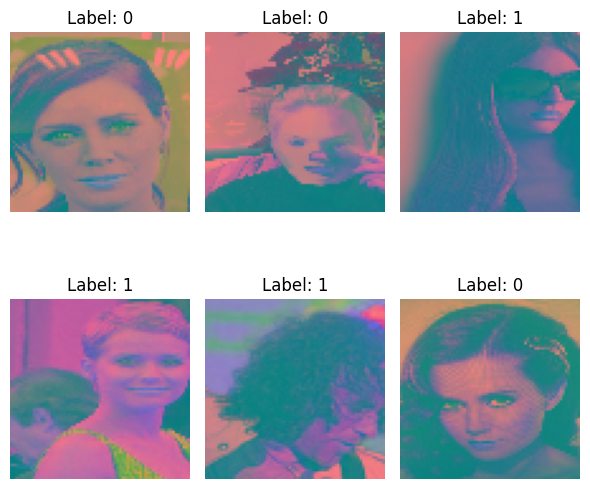

In [14]:
plt.figure(figsize=(6, 6))
for idx, (image, label) in enumerate(train_ds.take(6)):
    ax = plt.subplot(2, 3, idx + 1)
    ax.imshow(image+1)
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

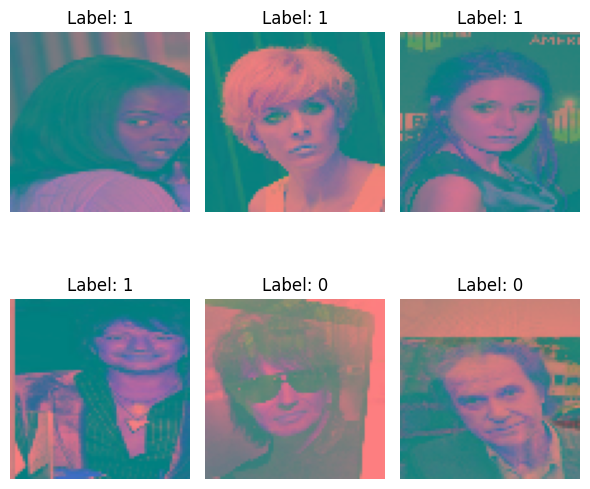

In [15]:
plt.figure(figsize=(6, 6))
for idx, (image, label) in enumerate(val_ds.take(6)):
    ax = plt.subplot(2, 3, idx + 1)
    ax.imshow(image+1)
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

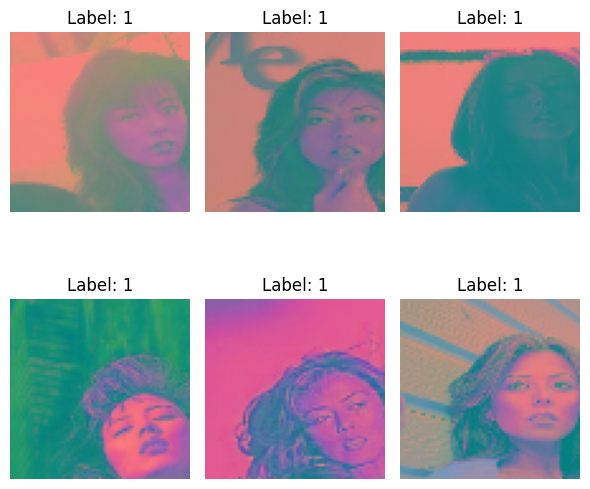

In [16]:
plt.figure(figsize=(6, 6))
for idx, (image, label) in enumerate(test_ds.take(6)):
    ax = plt.subplot(2, 3, idx + 1)
    ax.imshow(image+1)
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [17]:
def random_horizontal_flip(img, label):
    img = tf.image.random_flip_left_right(img)
    return img, label
def random_vertical_flip(img, label):
    img = tf.image.random_flip_up_down(img)
    return img, label
def random_rotation(img, label):
    img = tf.image.rot90(img, k=1) #k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    return img, label
def random_hue(img, label):
    img = tf.image.random_hue(img, 0.1)
    return img, labelargmax

In [18]:
"""
To train a model with this dataset you will want the data:
  To be well shuffled.
  To be batched.
  Batches to be available as soon as possible.
"""
batch_size_per_replica = 16
batch_size = batch_size_per_replica * strategy.num_replicas_in_sync
def configure_for_performance(ds, shuffle=False, augment=False):
    if augment:
        ds=ds.map(random_horizontal_flip)\
             .map(random_vertical_flip)\
             .map(random_rotation)\
             .map(random_hue)
            
    if shuffle:
        ds=ds.shuffle(1000)
    ds = ds.cache()
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [19]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

In [20]:
with strategy.scope():
    inputs = Input(shape=imgShape)
    # rescaling = Rescaling(1./127.5, offset=-1)(inputs)  # Rescale to [-1,1]
    top_dropout_rate = .4
    xception = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape=imgShape)
    xception.trainable = True
    x = xception(inputs)
    x = GlobalAveragePooling2D(name="avg_pool")(x)
    x = Dropout(top_dropout_rate, name="top_dropout")(x)
    x = Dense(units=512, activation='relu', name="pred")(x)
    output = Dense(1, activation='sigmoid')(x) # Linear activation
    xception_model = Model(inputs, output, name="xception")
    xception_model.compile(optimizer="adamax", loss='binary_crossentropy', metrics=['accuracy'])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
print("Ready to train. Training is starting!\n")
hist = xception_model.fit(train_ds, validation_data=val_ds, epochs=20,verbose=1)

Ready to train. Training is starting!

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 118s 247ms/step - accuracy: 0.7866 - loss: 0.4796 - val_accuracy: 0.9280 - val_loss: 0.3759
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.9535 - loss: 0.1242 - val_accuracy: 0.9640 - val_loss: 0.1345
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.9958 - loss: 0.0178 - val_accuracy: 0.9640 - val_loss: 0.1114
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.9990 - loss: 0.0048 - val_accuracy: 0.9720 - val_loss: 0.0736
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 1.0000 - loss: 8.2301e-04 - val_accuracy: 0.9720 - val_loss: 0.0676
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 1.0000 - loss: 2.4369e-04 - val_accuracy: 0.9760 - val_loss: 0.0632
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 1.0000 - loss: 1.4302e-04 - val_accuracy: 0.9760 - val_loss: 0.0646
Epoch 8/20
141/141 ━━━━━━━━━━━━

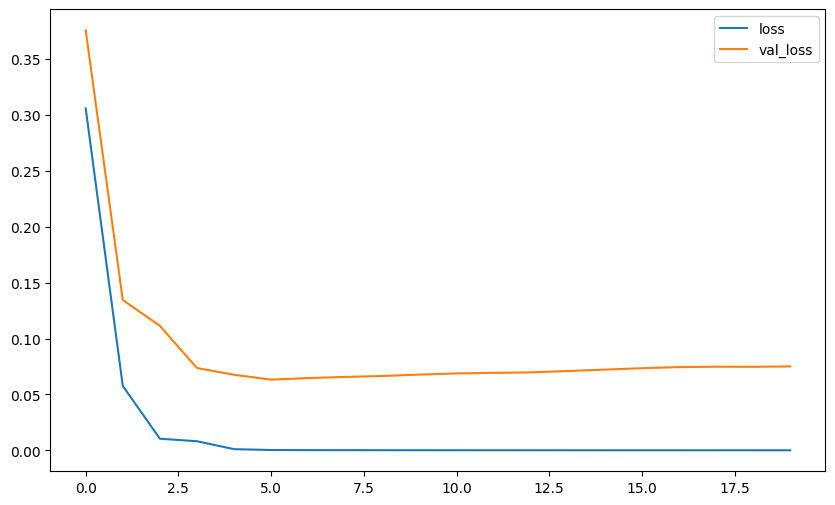

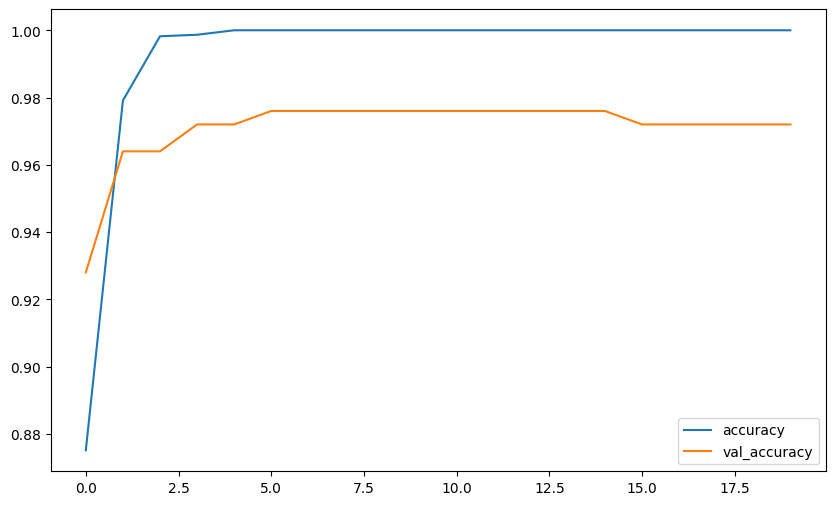

In [22]:
eps = range(len(hist.history["loss"]))
plt.figure(figsize=(10, 6))
plt.plot(eps, hist.history["loss"])
plt.plot(eps, hist.history["val_loss"])
plt.legend(["loss", "val_loss"])

eps = range(len(hist.history["accuracy"]))
plt.figure(figsize=(10, 6))
plt.plot(eps, hist.history["accuracy"])
plt.plot(eps, hist.history["val_accuracy"])
plt.legend(["accuracy", "val_accuracy"])

In [23]:
loss, accuracy = xception_model.evaluate(test_ds)
print(f"Test accuracy: {accuracy*100:.2f}%")

2100/2100 ━━━━━━━━━━━━━━━━━━━━ 577s 275ms/step - accuracy: 0.6594 - loss: 3.2603
Test accuracy: 63.78%


In [24]:
true_labels = []
for img_batch, labels_batch in test_ds:
    true_labels.extend(labels_batch.numpy())

In [25]:
def plot_confusion_matrix(true_labels,predictions,modelname):
    cm = confusion_matrix(true_labels, predictions)
    accuracy = accuracy_score(true_labels, predictions)
    print(f"{modelname} Accuracy: {accuracy*100:.2f}%")
    sns.heatmap(cm, annot=True)
    plt.title(f"Confusion Matrix for {modelname}")
    plt.show()

2100/2100 ━━━━━━━━━━━━━━━━━━━━ 47s 21ms/step
xception Accuracy: 66.69%


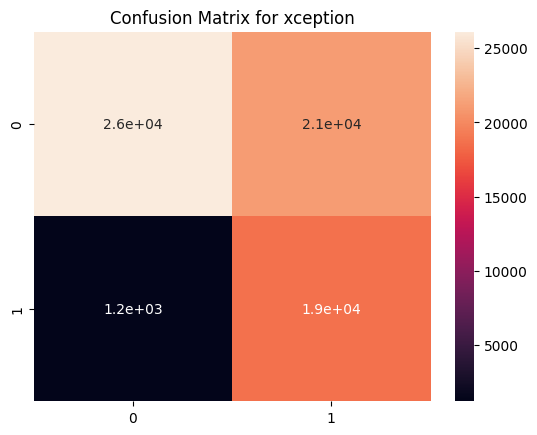

In [26]:
# squeeze removes dimensions of size 1 from the shape of a tensor.
predicted_labels_exception = np.array([1 if x >= 0.5 else 0 for x in tf.squeeze(xception_model.predict(test_ds))]) 
plot_confusion_matrix(true_labels, predicted_labels_exception,"xception")